# Node prediction based on graph topology similarities

All the computations are done in the file unsupervised.py. Please use this notebook only for testing and don't put any part of the actual implementation in it.

In [1]:
from unsupervised import *
import random
import numpy
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score,f1_score, recall_score,average_precision_score


SEED = "11"
random.seed(SEED)
np.random.seed(int(SEED))

### Create graph

In [2]:
import pandas as pd
import torch

# Load the entire movie data frame into memory:
movies_df = pd.read_csv("../dataset/ml-100k/u.item", sep='|', encoding='latin-1', header=None, usecols=[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], names=['movieId', 'title', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], index_col='movieId')
print(movies_df.head())
# row_1373 = movies_df.iloc[1372] # Indexing starts from 0, so 1372 is the 1373rd row
# print(row_1373) # The only movie with unknown rating

# Split genres and convert into indicator variables:
# Use only the genre columns for one-hot encoding:
genres = movies_df.iloc[:, 3:]

# Convert genre columns to numeric (0 or 1)
genres = genres.astype(int)
# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (1682, 19)  # 19 genres in total.

print(movie_feat)

# Load the entire ratings data frame into memory:
ratings_df = pd.read_csv("../dataset/ml-100k/u.data", sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
# Filter ratings above 3 to consider for recommendation
ratings_df = ratings_df[ratings_df['rating'] >= 4]

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()

# Load user demographic data:
users_df = pd.read_csv("../dataset/ml-100k/u.user", sep='|', header=None, names=['userId', 'age', 'gender', 'occupation', 'zip'])

"""
# One-hot encode categorical user features
user_feat_cat = pd.get_dummies(users_df[['gender', 'occupation']])
# Combine numerical 'age' attribute with one-hot encoded features
user_feat = pd.concat([users_df[['age']], user_feat_cat], axis=1)
"""

# user_feat = pd.get_dummies(users_df[['age', 'gender', 'occupation']])
user_feat = pd.get_dummies(users_df[['age',"occupation"]])
print(user_feat.shape)
# Convert all columns to numeric type
user_feat = user_feat.astype(int)

# Use user features as input features:
user_feat = torch.from_numpy(user_feat.values).to(torch.float)
print(user_feat.size())

# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
print(edge_index_user_to_movie.size())
# assert edge_index_user_to_movie.size() == (2, 100000)

print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)

                     title video_release_date  \
movieId                                         
1         Toy Story (1995)        01-Jan-1995   
2         GoldenEye (1995)        01-Jan-1995   
3        Four Rooms (1995)        01-Jan-1995   
4        Get Shorty (1995)        01-Jan-1995   
5           Copycat (1995)        01-Jan-1995   

                                                  IMDb_URL  unknown  Action  \
movieId                                                                       
1        http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
2        http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
3        http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
4        http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
5        http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

         Adventure  Animation  Children  Comedy  Crime  ...  Fantasy  \
movieId                       

In [3]:
edge_list = np.array(edge_index_user_to_movie)
biadjacency = np.zeros((np.unique(edge_list[0]).max()+1, np.unique(edge_list[1]).max()+1))
for user, movie in zip(edge_list[0], edge_list[1]):
    biadjacency[user, movie] = 1

In [4]:
data = Ml_100k()
data.rating_matrix.apply_(lambda a: 1 if a >= 4 else 0)
G = Graph(data.rating_matrix, evaluation=0.2)
G = Graph(biadjacency, evaluation=0.2)

nb users: 943, nb movies: 1682
nb users: 942, nb movies: 1447


### Compute metrics

In [5]:
G.compute_similarity("common-neighbors")
G.compute_similarity("adamic-adar")
G.compute_similarity("jaccard") 
G.compute_similarity("preferential-attachment")

Computing common neighbors: 100%|██████████| 1.36M/1.36M [00:00<00:00, 3.51M potential edge(s)/s]
Computing Adamic-Adar: 100%|██████████| 1.36M/1.36M [00:00<00:00, 3.38M potential edge(s)/s]
Computing Jaccard's coefficients: 100%|██████████| 1.36M/1.36M [00:00<00:00, 3.51M potential edge(s)/s]
Computing preferential attachment: 100%|██████████| 1.36M/1.36M [00:00<00:00, 3.50M potential edge(s)/s]


Eventually one might want to store the metrics in a file to not recompute them each time. If you feel the need for that proceed in a new chunk just below.

In [6]:
#G.similarities.save()

### Normalize the metrics between 0 and 1
The following chunk also plot the distribution of the similarities

In [7]:
G.similarities.normalize()

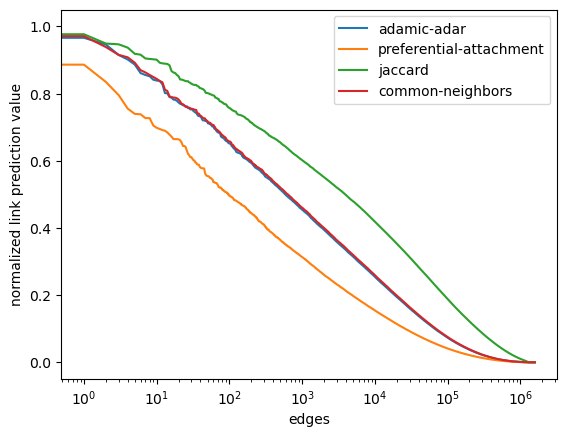

In [8]:
G.similarities.plot(xscale="log")

### Validation

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

def compute_and_plot_scores(metric, threshold, show=True):
    pred, gt=G.pred_true(metric,0)

    Binarypred = [1 if score > threshold else 0 for score in pred]
    ground_truth = list(map(int, gt))

    auc = roc_auc_score(ground_truth, pred)
    acc = accuracy_score(Binarypred,ground_truth)
    f1  = f1_score(Binarypred,ground_truth)
    pr  = precision_score(Binarypred,ground_truth)
    rec = recall_score(Binarypred,ground_truth)
    mean_avg_pres = average_precision_score(Binarypred,ground_truth)

    print()
    print(metric)
    print(f"Validation AUC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1: {f1:.4f}",)
    print(f"Precision: {pr:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"MAP: {mean_avg_pres:.4f}")
    if not show:
        return

    fpr, tpr, thres = roc_curve(ground_truth,pred)

    # Compute AUC
    auc_score = roc_auc_score(ground_truth,pred)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

100%|██████████| 22150/22150 [00:00<00:00, 973569.40it/s]


common-neighbors
Validation AUC: 0.7124
Accuracy: 0.5080
F1: 0.2195
Precision: 0.1271
Recall: 0.8031
MAP: 0.1190


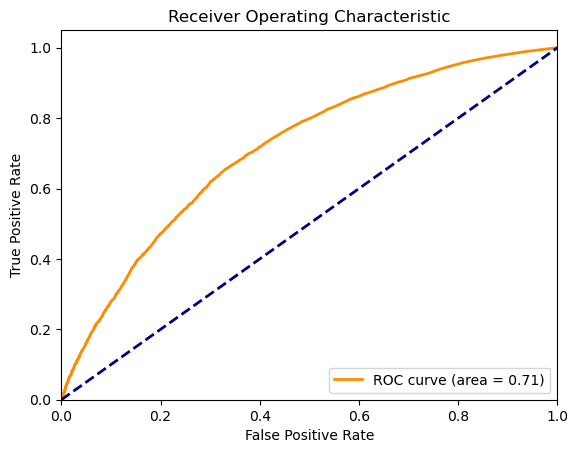

100%|██████████| 22150/22150 [00:00<00:00, 1204384.79it/s]



adamic-adar
Validation AUC: 0.7122
Accuracy: 0.5058
F1: 0.2121
Precision: 0.1222
Recall: 0.8012
MAP: 0.1144


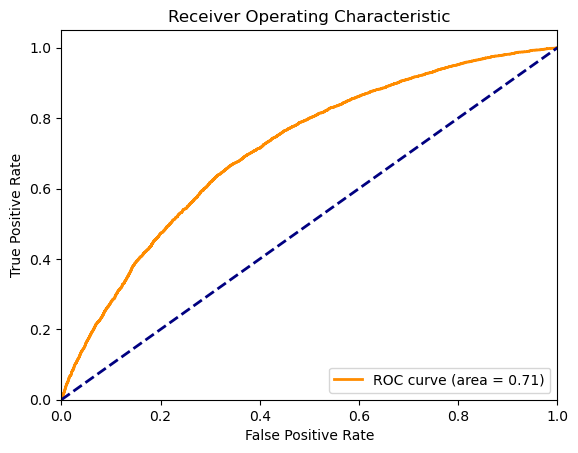

100%|██████████| 22150/22150 [00:00<00:00, 1307583.86it/s]



jaccard
Validation AUC: 0.7149
Accuracy: 0.5908
F1: 0.4916
Precision: 0.3635
Recall: 0.7588
MAP: 0.3387


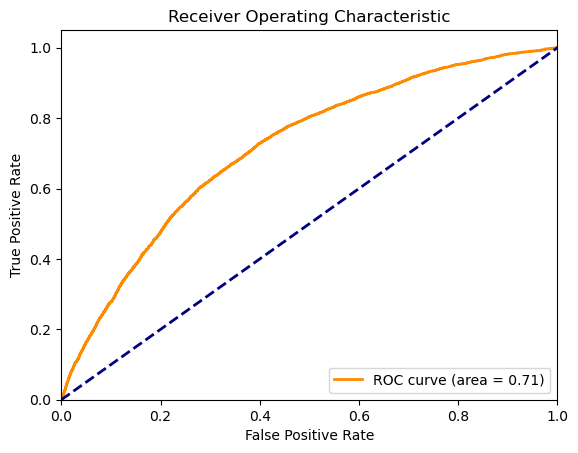

100%|██████████| 22150/22150 [00:00<00:00, 1295766.04it/s]



preferential-attachment
Validation AUC: 0.7124
Accuracy: 0.4830
F1: 0.0996
Precision: 0.0530
Recall: 0.8263
MAP: 0.0498


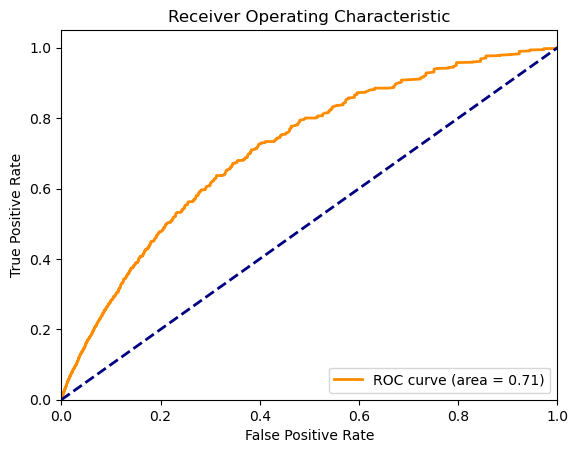

In [65]:
compute_and_plot_scores("common-neighbors", 0.1)
compute_and_plot_scores("adamic-adar", 0.1)
compute_and_plot_scores("jaccard", 0.1)
compute_and_plot_scores("preferential-attachment", 0.1)
# compute_and_plot_scores("common-neighbors", 0.016)
# compute_and_plot_scores("adamic-adar", 0.016)
# compute_and_plot_scores("jaccard", 0.073)
# compute_and_plot_scores("preferential-attachment", 0.009)

  0%|          | 0/22150 [00:00<?, ?it/s]

100%|██████████| 22150/22150 [00:00<00:00, 1106604.02it/s]


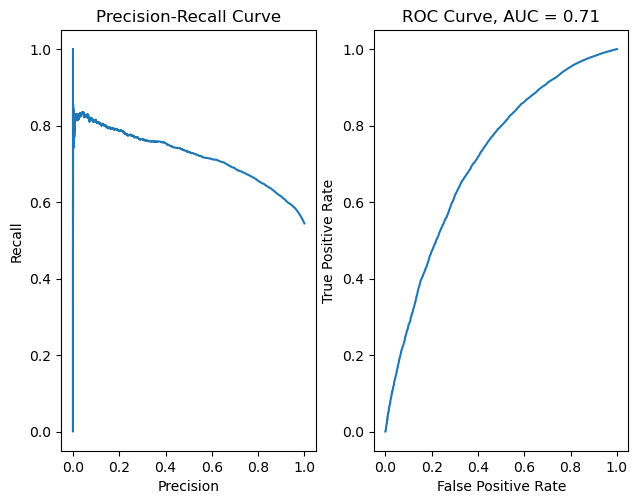

100%|██████████| 22150/22150 [00:00<00:00, 1129447.50it/s]


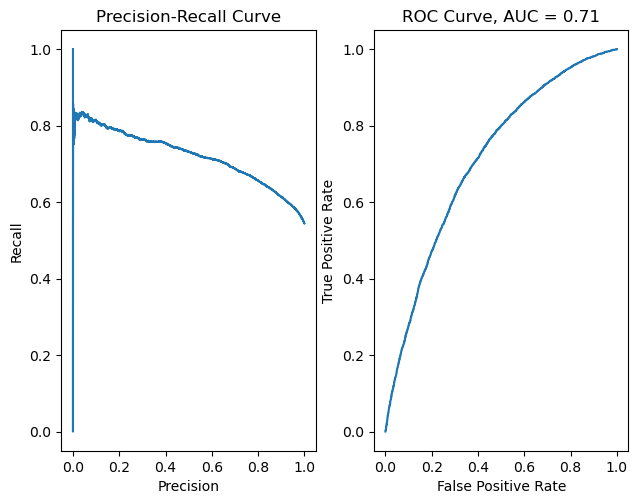

100%|██████████| 22150/22150 [00:00<00:00, 1391359.16it/s]


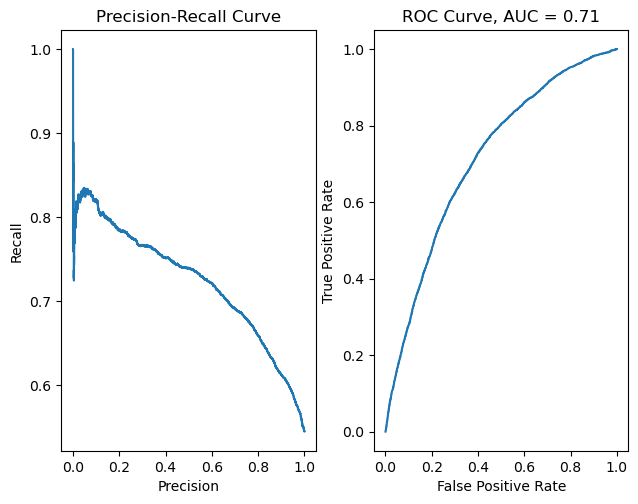

100%|██████████| 22150/22150 [00:00<00:00, 1368668.27it/s]


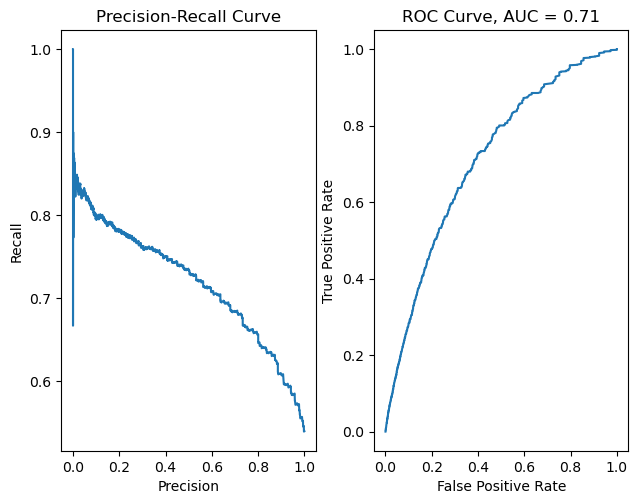

In [11]:
G.plot_ROC("common-neighbors")
G.plot_ROC("adamic-adar")
G.plot_ROC("jaccard")
G.plot_ROC("preferential-attachment")

## Fairness Evaluation

In [78]:
genres_names = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]


def plot_occurences(occurences, metric):
    # Generate basic bar plot
    genres = np.arange(len(occurences[0]))

    # Creating the bar plot
    width = 0.45  # the width of the bars
    fig, ax = plt.subplots()
    bars1 = ax.bar(genres - width / 2, occurences[0, :], width, label="Male")
    bars2 = ax.bar(genres + width / 2, occurences[1, :], width, label="Female")

    # Adding labels and title
    ax.set_xlabel("Genres")
    ax.set_ylabel("Number of User Ratings")
    ax.set_title(f"User Ratings of Movie Genres by Gender ({metric})")
    ax.set_xticks(genres)
    ax.set_xticklabels(genres_names)
    ax.legend()

    # Display the plot
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [79]:
def plot_normalized_occurences(occurences, metric, plot=True):
    # Generate normalized bar plot
    genres = np.arange(len(occurences[0]))

    # Normalize occurrences
    total_male = np.sum(occurences[0])
    total_female = np.sum(occurences[1])
    normalized_male = occurences[0] / total_male
    normalized_female = occurences[1] / total_female

    # sort genres by bias
    bias = normalized_female / normalized_male
    sorted_indexes = [14, 17, 9, 5, 0, 10, 16, 15, 1, 6, 12, 7, 8, 4, 2, 13, 11, 3]
    sorted_indexes = sorted(range(len(genres_names)), key=lambda i: bias[i])
    sorted_genres_names = [genres_names[i] for i in sorted_indexes]

    # Creating the bar plot
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    bars1 = ax.bar(
        genres - width / 2, normalized_male[sorted_indexes], width, label="Male"
    )
    bars2 = ax.bar(
        genres + width / 2, normalized_female[sorted_indexes], width, label="Female"
    )

    # Adding labels and title
    ax.set_xlabel("Genres")
    ax.set_ylabel("Normalized Number of Ratings")
    ax.set_title(f"Normalized User Ratings of Movie Genres by Gender ({metric})")
    ax.set_xticks(genres)
    ax.set_xticklabels(sorted_genres_names)
    ax.legend()

    # Display the plot
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return sorted_indexes

In [80]:
def plot_percentage(occurences, sorted_indexes, metric):
    # Percentage wise bar plot
    genres = np.arange(len(occurences[0]))

    # Stack male and female occurrences
    stacked_occurrences = np.vstack((occurences[0], occurences[1]))

    # Calculate total occurrences
    total_occurrences = np.sum(stacked_occurrences, axis=0)

    # Calculate percentages
    percentage_occurrences = stacked_occurrences / total_occurrences * 100

    percentage_occurrences = percentage_occurrences[:,sorted_indexes]
    sorted_genres_names = [genres_names[i] for i in sorted_indexes]

    # Plotting
    fig, ax = plt.subplots()
    bars1 = ax.bar(genres, percentage_occurrences[0], label='Male')
    bars2 = ax.bar(genres, percentage_occurrences[1], bottom=percentage_occurrences[0], label='Female')

    # Adding labels and title
    ax.set_xlabel('Genres')
    ax.set_ylabel('Percentage')
    ax.set_title(f"Movie Ratings of Movie Genres by Gender ({metric})")
    ax.set_xticks(genres)
    ax.set_xticklabels(sorted_genres_names)
    ax.legend()

    # Display the plot
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [81]:
movie_genres = np.array(movie_feat)
user_genders = np.array(users_df["gender"] == "F", dtype=int)


def eval_fairness(metric, threshold, occurences_plot=False, normalized_plot=True, percentage_plot=True):
    pred, gt, indices = G.pred_true(metric, 0, provide_indices=True)

    Binarypred = [1 if score > threshold else 0 for score in pred]
    ground_truth = list(map(int, gt))

    occurences = np.zeros(shape=(2, 18))

    for i in range(len(pred)):
        pred_i = Binarypred[i]
        user, movie = indices[i]
        if not pred_i:
            continue
        occurences[user_genders[user]] += movie_genres[movie,1:]
    
    if occurences_plot:
        plot_occurences(occurences, metric)
    sorted_indexes = plot_normalized_occurences(occurences, metric, plot=normalized_plot)
    if percentage_plot:
        plot_percentage(occurences, sorted_indexes, metric)


100%|██████████| 22150/22150 [00:00<00:00, 853299.47it/s]
/tmp/ipykernel_21280/2786514984.py:12: RuntimeWarning: invalid value encountered in divide
  bias = normalized_female / normalized_male


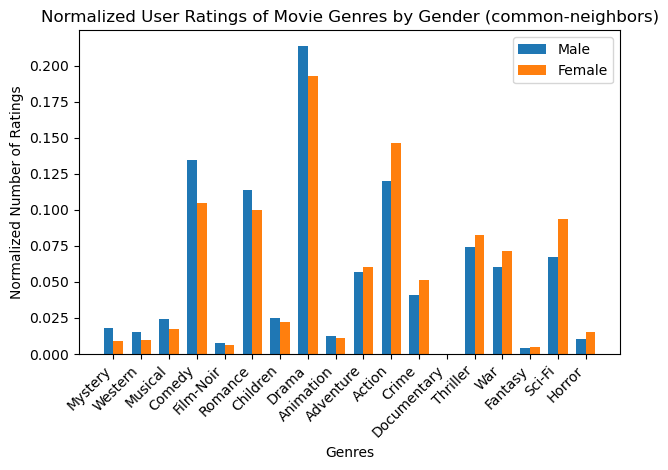

/tmp/ipykernel_21280/46688364.py:12: RuntimeWarning: invalid value encountered in divide
  percentage_occurrences = stacked_occurrences / total_occurrences * 100


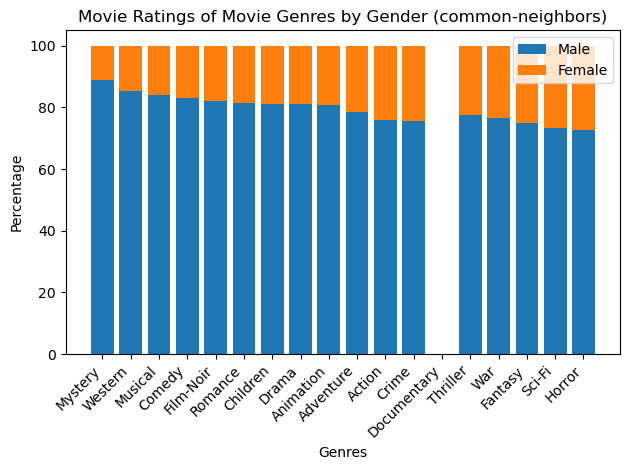

100%|██████████| 22150/22150 [00:00<00:00, 927980.44it/s]
/tmp/ipykernel_21280/2786514984.py:12: RuntimeWarning: invalid value encountered in divide
  bias = normalized_female / normalized_male


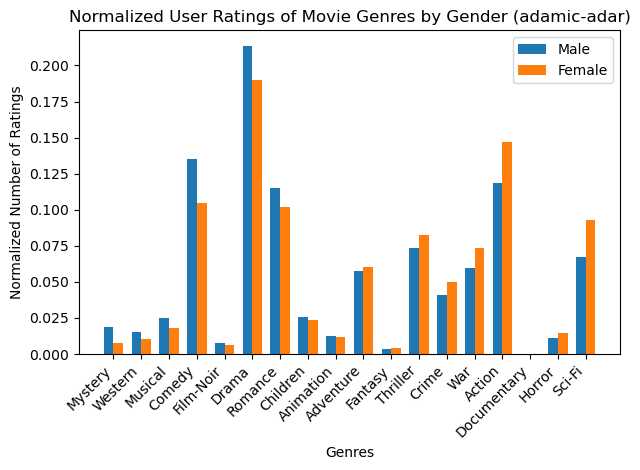

/tmp/ipykernel_21280/46688364.py:12: RuntimeWarning: invalid value encountered in divide
  percentage_occurrences = stacked_occurrences / total_occurrences * 100


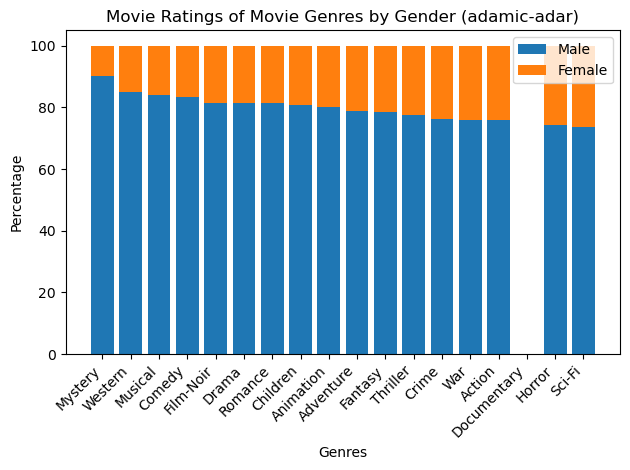

100%|██████████| 22150/22150 [00:00<00:00, 1046261.47it/s]


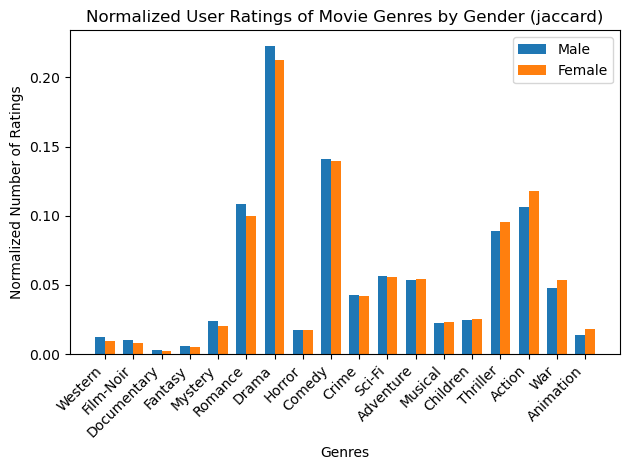

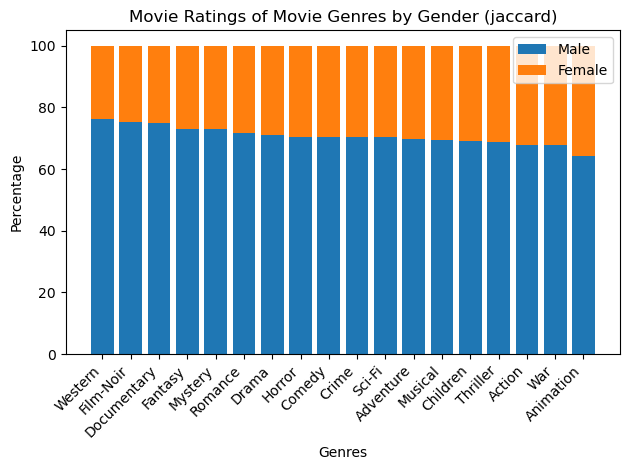

100%|██████████| 22150/22150 [00:00<00:00, 1313518.27it/s]
/tmp/ipykernel_21280/2786514984.py:12: RuntimeWarning: invalid value encountered in divide
  bias = normalized_female / normalized_male


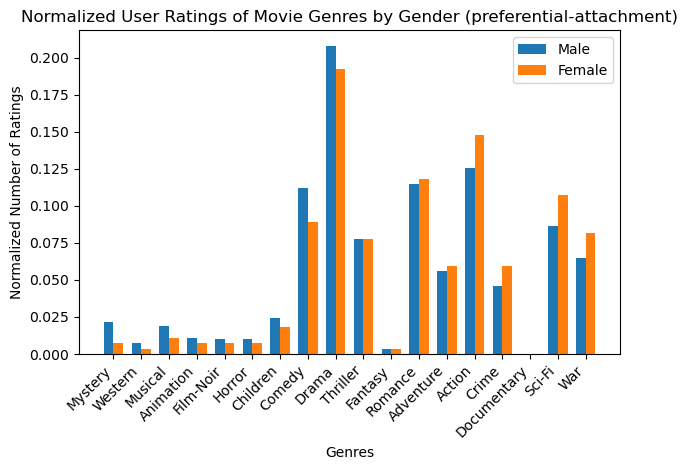

/tmp/ipykernel_21280/46688364.py:12: RuntimeWarning: invalid value encountered in divide
  percentage_occurrences = stacked_occurrences / total_occurrences * 100


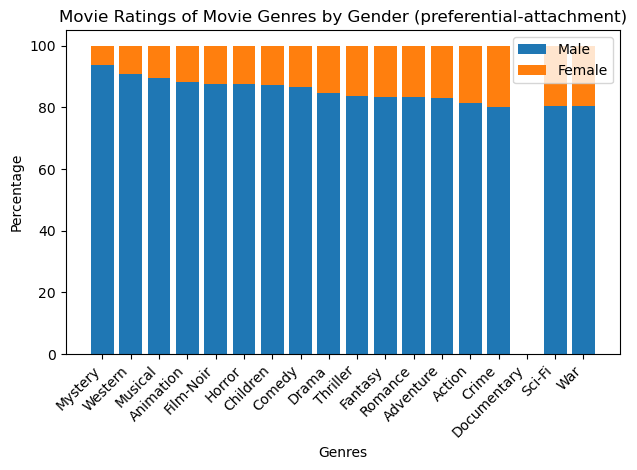

In [82]:
eval_fairness("common-neighbors", 0.1)
eval_fairness("adamic-adar", 0.1)
eval_fairness("jaccard", 0.1)
eval_fairness("preferential-attachment", 0.1)

In [83]:
set(G.test_set).isdisjoint((set(G.G_train.edges)))

True